## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('group == "treatment" and landing_page!="new_page" ').shape[0] + df.query('group == "control" and landing_page!="old_page" ').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
d1 =df.query('group == "treatment" and landing_page=="new_page" ') 
d2 =df.query('group == "control" and landing_page=="old_page" ')
df2= pd.concat([d1,d2])

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates(['user_id'])

In [15]:
df2['user_id'].duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_cont=df2.query('group == "control" ')['converted'].mean()
p_cont

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treat=df2.query('group == "treatment" ')['converted'].mean()
p_treat

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page=="new_page" ').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**No, I don't think there is a practical significant evidence that proves the new page leads to more conversions, even though there is a slight statistical significant evidence that the old page leads to a little bit more conversions. Here is why:**

1. Conversion probability of control group 'old page' = 0.1204
2. Conversion probabilty of treatment group 'new page' = 0.1188
**as we can see the difference is so tiny to notice, moreover:**
3. The probability of an individual receiving a new page = 0.5
**which means in turn:**
4. The probability of an individual receiving an old page is also 0.5
**Hence, the pages are equally distributed.**


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**#H0: Pnew<= Pold, 
H1: Pnew > Pold**

#H0: Pnew - Pold <= 0, H1: Pnew - Pold > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new= df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old= df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new= df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old= df2.query('group == "control"').shape[0]
n_old

145274

In [24]:
p_new - p_old

0.0

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted= np.random.choice([1,0], size= n_new, p=[p_new,(1- p_new)])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted= np.random.choice([1,0], size= n_old, p=[p_old,(1- p_old)])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
diff= new_page_converted.mean() - old_page_converted.mean()
diff

-0.00056693269839885874

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs=[]
for _ in range(10000):
    new_conv=np.random.choice([1,0], size= n_new, p=[p_new,(1- p_new)])
    old_conv=np.random.choice([1,0], size= n_old, p=[p_old,(1- p_old)])
    diffs= new_conv.mean() - old_conv.mean()
    p_diffs.append(diffs)
    
p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

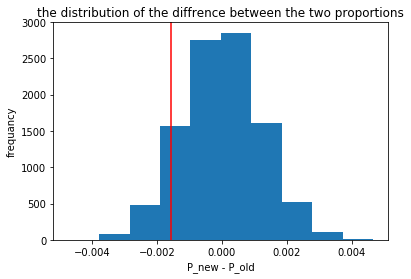

In [29]:
plt.hist(p_diffs)
plt.title('the distribution of the diffrence between the two proportions')
plt.xlabel('P_new - P_old')
plt.ylabel('frequancy')

obs_diff= p_treat - p_cont
plt.axvline(obs_diff, c='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_value=(p_diffs > obs_diff).mean()
p_value

0.90610000000000002

**Since our p-value is too big "p-value > 0.05", we fail to reject the null hypothesis; which means the old page's performance is better than the new page's or the same at least** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative = 'larger')
z_score,p_value

(-1.3109241984234394, 0.90505831275902449)

**In the built-in code above, I have set the alternative parameter equals to larger, larger means that the alternative hypothesis is p1 > p2,where p1 is the proportion of the new page and p2 of the old page.**

**Both values of z-score and p-value confirm that we fail to reject the null hypothesis, which means the old page conversion rate is better than or equal to the new page conversion rate.**


**We see that the findings in this part agree with the findings in parts j and k .**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should perform Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [34]:
df2['intercept'] =1
df2['ab_page']= pd.get_dummies(df['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
logm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logm.fit()
param = result.params

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
summary = result.summary2()
summary

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 09:46 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [37]:
np.exp(param)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [38]:
1/np.exp(param)

intercept    7.306593
ab_page      1.015102
dtype: float64

**The p-value associated with 'ab_page' = 0.1899, it differs from the value found in part II because our null and alternative hypothesis differ here:**

**H0: Pnew = Pold, H1: Pnew != Pold**

**Since we created a dummy variable 'ab_page', which refers to 'new_page', 'old_page' is automatically set as the baseline; we can conclude relationships with refrence to the baseline.**

**It is a good idea to take other factors like (age, time) into our regression model, to know which of them has the most influence on the conversion rate, but adding addtional features to our regression model has disadvantages like Multicollinearity (having the additional factors correlated to one another) and if there is a linear relationship to begin with or not.**

e. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
df3= pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
df_joined = df2.join(df3.set_index('user_id'),on ='user_id')

In [41]:
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [42]:
df_joined['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [43]:
df_joined[['US','CA','UK']]= pd.get_dummies(df_joined['country'])
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,UK
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [44]:
logm2 = sm.Logit(df_joined['converted'], df_joined[['intercept', 'US', 'CA']])
result2 = logm2.fit()
param2= result2.params

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [45]:
summary2=result2.summary2()
summary2

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 09:46 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
CA            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [46]:
np.exp(param2)

intercept    0.135779
US           0.960018
CA           1.009966
dtype: float64

In [47]:
1/np.exp(param2)

intercept    7.364925
US           1.041647
CA           0.990133
dtype: float64

### From the pervious model we conclude:

1. If an individual is from UK, it is 1.0416 times more likely to make a conversion than if he is from US , holding all other variables constant.

2. If an indivisual is from UK , it is 0.9901 times more likely to make a conversion than if he is from CA, holding all other variables constant.

**from these values which are very close to 1 time, we notice that there is no influence on the conversion rate coming from the country variable.**

f. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
logm3 = sm.Logit(df_joined['converted'], df_joined[['intercept','ab_page','US', 'CA']])
result3 = logm3.fit()
param3= result3.params

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [49]:
summary3=result3.summary2()
summary3

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 09:46 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
CA            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [50]:
np.exp(param3)

intercept    0.136795
ab_page      0.985168
US           0.960062
CA           1.009932
dtype: float64

In [51]:
1/np.exp(param3)

intercept    7.310207
ab_page      1.015056
US           1.041599
CA           0.990165
dtype: float64

### We can interpret the result as follows:

1. if an indivisual uses the new page, it is 1.0151 times more likely to make a conversion than if he uses the old page, holding all other variables constant.

2. If an indivisual is from US, it is 1.0416 times more likely to make a conversion than if he is from UK, holding all other variables constant.

3. If an indivisual is from CA , it is 0.9902 times more likely to make a conversion than if he is from UK, holding all other variables constant.

In [59]:
df_joined['US_ab_page'] = df_joined['US'] * df_joined['ab_page']
df_joined['CA_ab_page'] = df_joined['CA'] * df_joined['ab_page']
df_joined['UK_ab_page'] = df_joined['UK'] * df_joined['ab_page']
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,UK,US_ab_page,CA_ab_page,UK_ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,1,0,0


In [60]:
logm4 = sm.Logit(df_joined['converted'], df_joined[['intercept','US_ab_page','CA_ab_page','ab_page','US', 'CA']])
result4 = logm4.fit()
param4= result4.params

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [61]:
summary4=result4.summary2()
summary4

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-01-12 10:08 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
US_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
CA_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
CA           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

In [62]:
np.exp(param4)

intercept     0.137178
US_ab_page    0.954198
CA_ab_page    1.031896
ab_page       0.979646
US            0.982625
CA            0.994272
dtype: float64

In [63]:
1/np.exp(param4)

intercept     7.289813
US_ab_page    1.048001
CA_ab_page    0.969090
ab_page       1.020776
US            1.017682
CA            1.005761
dtype: float64

### Interpertation:

1. If an individual is from US and use a new page, he is 1.048001 times more likely to make a conversion than if he is from UK and using the new page , holding all other variables constant.

2. If an individual is from CA and use a new page, he is 0.969090 times more likely to make a conversion than if he is from US and use a new page , holding all other variables constant.

**Hence, There is no diffrence in the conversion rate if an indivisual uses one of the pages and he is in a specific country.**

3. If an indivisual uses the new page, it is 1.020776 times more likely to make a conversion than if he uses the old page, holding all other variables constant.

4. If an indivisual is from US, it is 1.017682 times more likely to make a conversion than if he is from UK, holding all other variables constant.

5. If an indivisual is from CA , it is 1.005761 times more likely to make a conversion than if he is from UK, holding all other variables constant.

**Therefore, There is no diffrence in the conversion rate if an indivisual uses one of the pages and he is in a specific country.**

## Conclusion:
In this project, we showed three ways to know which page has the highest performace ,by the converted rate, they are the probability, hypothesis testing, and the regression models, all of these ways give us evidences that the performace of the old page is better than the new one but with a tiny diffrence, so we can make a decision that keep the old page and reject the new one.